In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

## Описание данных

### Таблица `clients`
- `Дата добавления` - норм
- `Тип карты` - один у всех, 
- `Номер карты` - норм,
- `Моб.телефон` - норм, 
- `Фамилия` - +`Имя`+`Отчество` есть незначительное количество дубликатов, 
- `Имя`, 
- `Отчество`, 
- `Пол` - часть народе без пола, 
- `Дата рождения` - есть артефакты,
- `По рекомендации`  - один у всех, 
- `Всего бонусов` + , 
- `Активные бонусы` + ,
- `Неактивные бонусы` + , 
- `Получено бонусов` + , 
- `Использовано бонусов` + ,
- `Дата последней покупки` + , 
- `Покупок` + , 
- `Средний чек (руб)` + ,
- `Сумма покупок (руб)` + , 
- `Инстаграм`  - один у всех, 
- `ВКонтакте`  - один у всех, 
- `Одноклассники`  - один у всех,
- `Адрес`  - один у всех, 
- `Создан кассиром` - норм, 
- `Создан в магазине` - норм, 
- `Магазин`  - у части нет, 
- `Адрес.1`  - норм, у части  нет,
- `Согласие на СМС`  - норм, 
- `Согласие на рекламу` - по большей части норм, не до конца понятно что значит `Да*`


### Таблица `purchases`

- `Дата операции` - по ошибке, 
- `Тип операции` - нет пустых, подтипы
    - `Покупка` - все стандартно, начисляются бонусы, позиции в чеке все разные, 
    - `Подарок на день рождения близких`,
    - `Подарок на день рождения`, 
    - `Автоматическое сгорание`,
    - `Корректировка`, 
    - `Возврат`, 
    - `Подарок`
- `Моб.телефон`,
- `Списано бонусов`, 
- `Начислено бонусов`, 
- `№ чека`, 
- `Сумма покупки`,
- `Сумма скидки`, 
- `Оплата в рублях`, 
- `Оплата бонусами`, 
- `Тип карты`,
- `Номер карты`, 
- `Кассир`, 
- `Магазин`, 
- `Комментарий` - если поле `Тип операции` == `Возврат`, то комменнтарий тоже `Возврат`, в противном случаее `nan`
- `Товар`,
- `Количество`, 
- `Категория товара`, 
- `Дополнительная информация`

## Константы

In [3]:
# Дата выгрузки
EXTRACT_DATE = pd.to_datetime('2022-10-22')

# количество дней, после которых мы считаем, что клиент ушел
LEAVE = 400


RANDOM_STATE = 42

## EDA

In [4]:
client = pd.read_csv('data/clients.csv')

In [5]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21004 entries, 0 to 21003
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              21004 non-null  int64  
 1   Дата добавления         21004 non-null  object 
 2   Тип карты               21004 non-null  object 
 3   Номер карты             21004 non-null  object 
 4   Моб.телефон             21004 non-null  object 
 5   Фамилия                 21004 non-null  object 
 6   Имя                     21004 non-null  object 
 7   Отчество                21004 non-null  object 
 8   Пол                     20039 non-null  object 
 9   Дата рождения           20836 non-null  object 
 10  По рекомендации         0 non-null      float64
 11  Всего бонусов           21004 non-null  float64
 12  Активные бонусы         21004 non-null  float64
 13  Неактивные бонусы       21004 non-null  int64  
 14  Получено бонусов        21004 non-null

#### Поправим очевидные опечатки

In [6]:
print(client.loc[1045, 'Дата рождения'])
print(client.loc[2367, 'Дата рождения'])
print(client.loc[10084, 'Дата рождения'])

7198-04-10 00:00:00
2989-11-08 00:00:00
4199-01-08 00:00:00


In [7]:
client.loc[1045, 'Дата рождения'] = '1987-04-10 00:00:00'
client.loc[2367, 'Дата рождения'] = '1989-11-08 00:00:00'
client.loc[10084, 'Дата рождения'] = '1994-01-08 00:00:00'
client['Дата добавления'] = pd.to_datetime(client['Дата добавления'])
client['Дата рождения'] = pd.to_datetime(client['Дата рождения'])
client['Дата последней покупки'] = pd.to_datetime(client['Дата последней покупки'])

Оставим себе только тех кто  что-то покупал

In [8]:
df_client = client[client['Покупок'] > 0][['Дата добавления',
                                           'Моб.телефон', 'Пол', 'Дата рождения',
                                           'Всего бонусов', 'Получено бонусов', 'Использовано бонусов',
                                           'Дата последней покупки', 'Покупок', 'Средний чек (руб)',
                                           'Сумма покупок (руб)',
                                           'Согласие на СМС', 'Согласие на рекламу']].copy()

df_client['Пол'] = df_client['Пол'].fillna('None')
df_client.head()

,Дата добавления,Моб.телефон,Пол,Дата рождения,Всего бонусов,Получено бонусов,Использовано бонусов,Дата последней покупки,Покупок,Средний чек (руб),Сумма покупок (руб),Согласие на СМС,Согласие на рекламу
1,2022-10-22,babb008e0127d702f62789baf388dbd6,М,1986-09-16,541.0,541,0.0,2022-10-22,1,3370.0,3370.0,Да,Да
2,2022-10-22,f8b8aec2bee7469bbc46943fb484c303,М,1995-03-01,71.0,71,0.0,2022-10-22,1,2886.0,2886.0,Да,Да
3,2022-10-22,8da4709238ea00c4bf84418353041eb2,Ж,1980-06-12,56.0,56,0.0,2022-10-22,2,899.0,1798.0,Да,Да
5,2022-10-22,f832221776781b7db05c65d3f6610d5f,None,1998-04-06,27.0,27,0.0,2022-10-22,1,899.0,899.0,Да,Да
6,2022-10-22,a6ed0896839ab6359512509e058a662a,М,1989-02-01,0.0,0,0.0,2022-10-22,1,269.0,269.0,Да,Да


In [9]:
df_client['Дней с последней покупки'] = (EXTRACT_DATE - df_client['Дата последней покупки']).dt.days.astype(int)

In [10]:
df_client['Возраст'] = (EXTRACT_DATE.year - df_client['Дата рождения'].dt.year).fillna(35).astype(int)

#### Загрузим данные о покупках

In [11]:
purchases = pd.read_csv('data/purchases.csv')

/var/folders/wb/jdb8bx8n6dqf_wpb7c0kp4j40000gn/T/ipykernel_6275/3478648184.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  purchases = pd.read_csv('data/purchases.csv')


In [12]:
def data_analysys(dataframe):
    #dataframe = pd.read_csv(filename)

    #print(f'Dataframe name: {filename}')
    display(dataframe.head())
    display(dataframe.info())
    display(dataframe.describe(include='all'))

    for column in dataframe.columns:
        unique_counts = dataframe[column].unique()
        unique_values = dataframe[column].value_counts(dropna=False).to_dict()

        if len(unique_counts) <= 10:
            print(f'`{column}` has values {unique_values}')
        elif len(unique_counts) == dataframe[column].shape[0]:
            print(f'`{column}` has unique values')
        else:
            print(f'`{column}` has non-unique values, count of uniue: {len(unique_values)}')


In [13]:
data_analysys(purchases)

,Unnamed: 0,Дата операции,Тип операции,Моб.телефон,Списано бонусов,Начислено бонусов,№ чека,Сумма покупки,Сумма скидки,Оплата в рублях,Оплата бонусами,Тип карты,Номер карты,Кассир,Магазин,Комментарий,Товар,Количество,Категория товара,Дополнительная информация
0,0,2022-10-23,Покупка,e41ae15e64ed6f2d2b37caf2023903b0,0.0,0.0,60560.0,6.0,0.0,6.0,0.0,Стандартная,c1a0b6a21175d40691f046a448ed33a7,Касса1,1.0,NaN,NaN,1.0,NaN,NaN
1,1,2022-10-23,Покупка,e41ae15e64ed6f2d2b37caf2023903b0,499.0,45.0,60560.0,4999.0,0.0,4500.0,499.0,Стандартная,c1a0b6a21175d40691f046a448ed33a7,Касса1,1.0,NaN,NaN,1.0,Начисление 1 списание 10,"Начисление бонусов: 45 (Основные настройки, ка..."
2,2,2022-10-23,Покупка,3281acace8e8d42572c5a0e3ab67a938,406.1,108.0,60559.0,3999.0,0.0,3592.9,406.1,Стандартная,f2f76029fc6490531b997348bce55922,Касса3,2.0,NaN,NaN,1.0,Начисление 3 списание 20,"Начисление бонусов: 108 (Основные настройки, к..."
3,3,2022-10-23,Покупка,3281acace8e8d42572c5a0e3ab67a938,429.9,39.0,60559.0,4299.0,0.0,3869.1,429.9,Стандартная,f2f76029fc6490531b997348bce55922,Касса3,2.0,NaN,NaN,1.0,Начисление 1 списание 10,"Начисление бонусов: 39 (Основные настройки, ка..."
4,4,2022-10-23,Покупка,5b8b71de66e260723cf2d59984850c3e,0.0,4.0,60558.0,150.0,22.5,127.5,0.0,Стандартная,c74b3c64ae4ec50ad0f75c817fc32837,Касса1,1.0,NaN,NaN,1.0,Начисление 3 списание 20,"Скидка: 22,5 (Внешняя скидка);Начисление бонус..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260922 entries, 0 to 260921
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 260922 non-null  int64  
 1   Дата операции              260922 non-null  object 
 2   Тип операции               260922 non-null  object 
 3   Моб.телефон                260922 non-null  object 
 4   Списано бонусов            260205 non-null  float64
 5   Начислено бонусов          259639 non-null  float64
 6   № чека                     111247 non-null  float64
 7   Сумма покупки              111247 non-null  float64
 8   Сумма скидки               111247 non-null  float64
 9   Оплата в рублях            111247 non-null  float64
 10  Оплата бонусами            260922 non-null  float64
 11  Тип карты                  109827 non-null  object 
 12  Номер карты                260922 non-null  object 
 13  Кассир                     11

None

,Unnamed: 0,Дата операции,Тип операции,Моб.телефон,Списано бонусов,Начислено бонусов,№ чека,Сумма покупки,Сумма скидки,Оплата в рублях,Оплата бонусами,Тип карты,Номер карты,Кассир,Магазин,Комментарий,Товар,Количество,Категория товара,Дополнительная информация
count,260922.000000,260922,260922,260922,260205.000000,259639.000000,111247.000000,111247.000000,111247.000000,111247.000000,260922.000000,109827,260922,111210,100004.000000,1420,0.0,111247.0,106171,49627
unique,NaN,934,7,20903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20903,3,NaN,1,NaN,NaN,4,21661
top,NaN,2022-01-16,Покупка,840e9c1385d8ba15cf74c89b11537405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Стандартная,fa21f6201f1158f5c36fedcb97fd9d28,Касса1,NaN,Возврат,NaN,NaN,Начисление 3 списание 20,Начисление бонусов: 3 (Основные настройки);
freq,NaN,1122,109827,451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109827,451,61081,NaN,1420,NaN,NaN,68559,746
mean,130460.500000,NaN,NaN,NaN,136.682393,152.458923,29700.972889,1351.815442,24.415468,1295.449842,13.621102,NaN,NaN,NaN,1.333577,NaN,NaN,1.0,NaN,NaN
std,75321.837806,NaN,NaN,NaN,214.442089,220.828703,17248.971301,3278.701726,194.988409,3187.996253,66.167461,NaN,NaN,NaN,0.471493,NaN,NaN,0.0,NaN,NaN
min,0.000000,NaN,NaN,NaN,0.000000,0.000000,1.000000,-54312.000000,-5598.000000,-54312.000000,-1048.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,NaN
25%,65230.250000,NaN,NaN,NaN,0.000000,0.000000,14422.000000,155.000000,0.000000,150.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,NaN
50%,130460.500000,NaN,NaN,NaN,0.000000,12.000000,29953.000000,475.000000,0.000000,438.010000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,NaN
75%,195690.750000,NaN,NaN,NaN,348.760000,500.000000,43775.000000,1300.000000,0.000000,1255.000000,0.000000,NaN,NaN,NaN,2.000000,NaN,NaN,1.0,NaN,NaN


`Unnamed: 0` has unique values
`Дата операции` has non-unique values, count of uniue: 934
`Тип операции` has values {'Покупка': 109827, 'Автоматическое сгорание': 78339, 'Подарок на день рождения близких': 38493, 'Подарок на день рождения': 28863, 'Подарок': 3148, 'Возврат': 1420, 'Корректировка': 832}
`Моб.телефон` has non-unique values, count of uniue: 20903
`Списано бонусов` has non-unique values, count of uniue: 10237
`Начислено бонусов` has non-unique values, count of uniue: 1021
`№ чека` has non-unique values, count of uniue: 60497
`Сумма покупки` has non-unique values, count of uniue: 3872
`Сумма скидки` has non-unique values, count of uniue: 6510
`Оплата в рублях` has non-unique values, count of uniue: 27592
`Оплата бонусами` has non-unique values, count of uniue: 10596
`Тип карты` has values {nan: 151095, 'Стандартная': 109827}
`Номер карты` has non-unique values, count of uniue: 20903
`Кассир` has values {nan: 149712, 'Касса1': 61081, 'Касса3': 44361, 'Касса2': 5768}
`Магазин

Приведем даты к формату даты

In [14]:
purchases['Дата операции'] = pd.to_datetime(purchases['Дата операции'])

In [15]:
purchases = purchases.sort_values(['Дата операции', ], ascending=True)

In [16]:
purchases[['Списано бонусов', 'Начислено бонусов', 'Сумма покупки',
           'Сумма скидки', 'Оплата в рублях', 'Оплата бонусами', 'Кассир', 'Магазин']] = purchases[
    ['Списано бонусов', 'Начислено бонусов', 'Сумма покупки',
     'Сумма скидки', 'Оплата в рублях', 'Оплата бонусами', 'Кассир', 'Магазин']].fillna(0)

In [17]:
def display_descrete_variables(data: pd.DataFrame, variables: list, length=4):
    count = len(variables)

    row = min(length, count)
    col = (count // length) + (1 if (count % length) else 0)

    fig, axes = plt.subplots(col, row, figsize=(length * 7, row * 6))

    if count > 1:

        for i, variable in enumerate(variables):
            r = i // length
            c = i % length
            # print(r,c)
            try:
                chart = sns.countplot(data=data, x=variable, ax=axes[r][c]).set_title(variable)
                axes[r][c].set_xticklabels(axes[r][c].get_xticklabels(), rotation=45)
            except:
                chart = sns.countplot(data=data, x=variable, ax=axes[c])
                axes[c].set_xticklabels(axes[c].get_xticklabels(), rotation=45)

    else:
        sns.countplot(data=data, x=variables[0], ax=axes).set_title(variables[0])
    plt.show()

In [18]:
def getdiff(item):
    if type(item) == list and len(item) > 0:
        return list(pd.Series(item).diff().dt.days[1:])
    else:
        return []

In [19]:
def getdata(data, phone, recalculate, target):
    result = {}

    result['Моб.телефон'] = phone
    result['target'] = target

    chunk = data[data['Моб.телефон'] == phone]

    if recalculate:
        last_purchases_data = chunk[chunk['Тип операции'] == 'Покупка']['Дата операции'].max()
        chunk = chunk[chunk['Дата операции'] < last_purchases_data]

    # ======================= ПОКУПКИ =====================
    df_1 = chunk[chunk['Тип операции'] == 'Покупка'].groupby('№ чека').agg({
        'Моб.телефон': max,
        'Дата операции': max,
        'Списано бонусов': sum,
        'Начислено бонусов': sum,
        'Оплата в рублях': sum,
        'Оплата бонусами': sum,
        'Сумма покупки': [sum, 'count'],
        'Сумма скидки': sum,
        'Тип карты': max,
        'Кассир': max,
        'Магазин': max,
    })

    df_1.columns = [
        'Моб.телефон',
        'Дата операции',
        'Списано бонусов',
        'Начислено бонусов',
        'Оплата в рублях',
        'Оплата бонусами',
        'Сумма покупки',
        'Количество позиций в чеке',
        'Сумма скидки',
        'Тип карты',
        'Кассир',
        'Магазин', ]

    df_1['count_of_purchases'] = 1
    #display(df_purchases_grouped)
    #return

    df_1_ = df_1.groupby(['Моб.телефон']).agg({
        'Дата операции': [lambda x: list(x), 'count'],
        'Списано бонусов': sum,
        'Начислено бонусов': sum,
        'Оплата в рублях': sum,
        'Оплата бонусами': sum,
        'Сумма покупки': [lambda x: list(x), sum],
        'Сумма скидки': sum,
        #'Тип карты': max,
        'Количество позиций в чеке': [lambda x: list(x), sum],
        'count_of_purchases': sum,
        'Магазин': [lambda x: list(x), lambda x: set(x)],  # cписок магазинов

    })

    df_1_.columns = [
        'Даты покупок',
        'Количество покупок',
        'Потрачено бонусов',
        'Начислено бонусов за покупки',
        'Оплата в рублях',
        'Оплата бонусами',
        'История покупок',
        'Сумма покупок',
        'Сумма скидок',
        #'Тип карты',
        'История позиций в чеке',
        'Количество позиций в чеках',
        'count_of_purchases',
        'Список магазинов по покупкам',
        'Множество магазинов',
    ]

    #display(df_1_)
    try:

        r = df_1_.loc[phone]
    except:
        #print(phone)
        return None

    result['Средний чек'] = r['Сумма покупок'] / r['Количество покупок']
    result['Сумма покупок'] = r['Сумма покупок']
    result['Количество покупок'] = r['Количество покупок']
    result['Потрачено бонусов'] = r['Оплата бонусами']
    result['Начислено бонусов за покупки'] = r['Начислено бонусов за покупки']
    result['Количество покупок'] = r['Количество покупок']
    result['Количество позиций в чеках'] = r['Количество позиций в чеках']
    result['Магазин 1'] = 1 in r['Множество магазинов']
    result['Магазин 2'] = 2 in r['Множество магазинов']
    result['Интернет'] = 0 in r['Множество магазинов']

    # ======================= Возвраты =====================

    df_2 = chunk[chunk['Тип операции'] == 'Возврат'][[
        'Моб.телефон',
        'Дата операции',
        'Списано бонусов',
        'Начислено бонусов',
        'Оплата в рублях',
        'Оплата бонусами',
        'Сумма покупки',
        'Сумма скидки',
        'Тип карты',
        'Кассир',
        'Магазин', ]]

    df_2['count_of_return'] = 1
    df_2.head()

    df_2_ = df_2.groupby(['Моб.телефон']).agg({
        'Дата операции': [lambda x: list(x), 'count'],
        'Сумма покупки': [lambda x: list(x), sum],
        'count_of_return': sum,
        'Магазин': [lambda x: list(x), lambda x: set(x)],  # cписок магазинов

    })

    df_2_.columns = ['Даты возврата',
                     'Количество возвратов',
                     'История возвратов',
                     'Сумма возвратов',
                     'count_of_return',
                     'Список магазинов по возвратов',
                     'Множество магазинов по возвратам']

    try:
        r = df_2_.loc[phone]

        result['Количество возвратов'] = r['Количество возвратов']
        result['Сумма возвратов'] = r['Сумма возвратов'] * -1
    except KeyError:
        result['Количество возвратов'] = 0
        result['Сумма возвратов'] = 0

    # ==== Начисления =========

    df_3 = chunk[(chunk['Тип операции'].isin([
        'Корректировка',
        'Подарок на день рождения близких',
        'Подарок на день рождения',
        'Подарок',
    ]))].copy()  #& (purchases['Оплата бонусами']<0)]#['Оплата бонусами'].value_counts()#.describe()

    #df_bonuses.head()

    df_3_ = df_3.groupby(['Моб.телефон']).agg({
        'Дата операции': [lambda x: list(x), 'count'],
        'Начислено бонусов': [lambda x: list(x), 'count', sum],
        'Тип операции': [lambda x: list(x), lambda x: set(x)]
    })

    df_3_.columns = [
        'Даты начисления бон',
        'Количество начислений бон',
        'История начисления бон',
        'count',
        'Всего начислено бон',
        'Причина начисления',
        'Список причин']

    try:
        r = df_3_.loc[phone]

        result['Количество начислений бон'] = r['Количество начислений бон']
        result['Всего начислено бон'] = r['Всего начислено бон']
    except KeyError:
        result['Количество начислений бон'] = 0
        result['Всего начислено бон'] = 0

    # ==== Списания =========

    df_4 = chunk[(chunk['Тип операции'].isin([
        'Автоматическое сгорание',
    ]))].copy()

    df_4_ = df_4.groupby(['Моб.телефон']).agg({
        'Дата операции': [lambda x: list(x), 'count'],
        'Списано бонусов': [lambda x: list(x), 'count', sum],
    })

    df_4_.columns = ['Даты списания бон', 'Количество списаний бон', 'История списаний бон', 'count',
                     'Всего списано бонусов']

    try:
        r = df_4_.loc[phone]

        result['Количество списаний бон'] = r['Количество списаний бон']
        result['Всего списано бонусов'] = r['Всего списано бонусов']
    except KeyError:
        result['Количество списаний бон'] = 0
        result['Всего списано бонусов'] = 0

    return result

# getdata(purchases, 'e4f3256ee4ca7c04371688f53f098715', 0)
#getdata(purchases, '471d5a3e2da3fe1f2a4a451f34e7af56', 1, 0)

In [20]:
#purchases[purchases['Моб.телефон'] == '471d5a3e2da3fe1f2a4a451f34e7af56']

In [21]:
#client[client['Моб.телефон'] == '471d5a3e2da3fe1f2a4a451f34e7af56'].loc[550]

In [22]:
valuable_feature = ['Пол',
                    'Средний чек',
                    # 'Сумма покупок (руб)',
                    'Согласие на СМС',
                    'Согласие на рекламу',
                    'Возраст',
                    'Количество покупок',
                    'Потрачено бонусов',
                    'Начислено бонусов за покупки',
                    'Сумма покупок',
                    'Сумма скидок',
                    'Количество позиций в чеках',
                    'Множество магазинов',
                    'Количество возвратов',
                    'Сумма возвратов',
                    'Количество начислений бон',
                    'Всего начислено бон',
                    'Количество списаний бон',
                    'Всего списано бонусов'
                    ]

# Собираем таргет

#### Пользователи с одной покупкой, которых не было больше порогового значения

In [23]:
leaving_with_1 = df_client[(df_client['Покупок'] == 1) & (df_client['Дней с последней покупки'] > LEAVE)]['Моб.телефон']
leaving_with_1.shape

(4992,)

#### Пользователи с несколькими покупками, которых не было больше порогового значения

In [24]:
leaving_with_several = df_client[(df_client['Покупок'] > 1) & (df_client['Дней с последней покупки'] > LEAVE)][
    'Моб.телефон']
leaving_with_several.shape

(2444,)

#### Пользователи с несколькими покупками, которые не ушли

In [25]:
not_leaving = df_client[(df_client['Покупок'] > 1) & (df_client['Дней с последней покупки'] <= LEAVE)]['Моб.телефон']
not_leaving.shape

(8931,)

### Собираем датасет

Во первых добавим всех кто ушел после первой покупеи и присвоим им тагет `1`

Потом всех кто ушел после нескольких покупок и так же присвоим им тагет `1`

Потом сформируем данные у оставшихся клиентов следующим образом - откинем последнюю покупку и  всю информацию, полученную после момента последней покупки включительно и присвоим им таргет `0`

Таким образом мы можем попытаться решить зпдачу прогнощирования того совершит ли клиент следующую покупку или нет

In [26]:
%%time

rezult = []

exeption_phone = set()

for item in leaving_with_1:
    r = getdata(purchases, item, 0, 1)
    if r:
        rezult.append(r)
    else:
        exeption_phone.add(item)

for item in leaving_with_several:
    r = getdata(purchases, item, 0, 1)
    if r:
        rezult.append(r)
    else:
        exeption_phone.add(item)

for item in not_leaving:
    r = getdata(purchases, item, 1, 0)
    if r:
        rezult.append(r)
    else:
        exeption_phone.add(item)



CPU times: user 5min 1s, sys: 1.62 s, total: 5min 3s
Wall time: 5min 3s


In [27]:
result_df = pd.DataFrame(rezult)
result_df.head()

,Моб.телефон,target,Средний чек,Сумма покупок,Количество покупок,Потрачено бонусов,Начислено бонусов за покупки,Количество позиций в чеках,Магазин 1,Магазин 2,Интернет,Количество возвратов,Сумма возвратов,Количество начислений бон,Всего начислено бон,Количество списаний бон,Всего списано бонусов
0,8a5e8ea10f387771e8a21be0b47a40b6,1,980.0,980.0,1,0.0,41.0,2,True,False,False,0,0.0,1,500.0,1,500.0
1,4b034f7c837668c975a8b17fa02a41ca,1,568.0,568.0,1,0.0,17.0,1,True,False,False,0,0.0,2,1000.0,2,1000.0
2,829db8f56ed0b6ae1b950408871628fd,1,264.0,264.0,1,0.0,9.0,2,True,False,False,0,0.0,2,1000.0,2,1000.0
3,ec1dcf689fdc9d6ebea287feccf3b308,1,1495.0,1495.0,1,0.0,75.0,1,True,False,False,0,0.0,4,2000.0,3,1500.0
4,f7856191beb96ce12364140f0ddb2c24,1,1875.0,1875.0,1,0.0,67.0,2,False,True,False,0,0.0,2,1000.0,2,1000.0


In [28]:
df_info = df_client[['Моб.телефон', 'Пол', 'Согласие на СМС', 'Согласие на рекламу', 'Возраст', ]]

In [29]:
df_data = result_df.merge(df_info, how='left', on='Моб.телефон')
df_data.head()

,Моб.телефон,target,Средний чек,Сумма покупок,Количество покупок,Потрачено бонусов,Начислено бонусов за покупки,Количество позиций в чеках,Магазин 1,Магазин 2,...,Количество возвратов,Сумма возвратов,Количество начислений бон,Всего начислено бон,Количество списаний бон,Всего списано бонусов,Пол,Согласие на СМС,Согласие на рекламу,Возраст
0,8a5e8ea10f387771e8a21be0b47a40b6,1,980.0,980.0,1,0.0,41.0,2,True,False,...,0,0.0,1,500.0,1,500.0,М,Нет,Да*,39
1,4b034f7c837668c975a8b17fa02a41ca,1,568.0,568.0,1,0.0,17.0,1,True,False,...,0,0.0,2,1000.0,2,1000.0,Ж,Да,Да,44
2,829db8f56ed0b6ae1b950408871628fd,1,264.0,264.0,1,0.0,9.0,2,True,False,...,0,0.0,2,1000.0,2,1000.0,Ж,Да,Да,34
3,ec1dcf689fdc9d6ebea287feccf3b308,1,1495.0,1495.0,1,0.0,75.0,1,True,False,...,0,0.0,4,2000.0,3,1500.0,Ж,Да,Да,35
4,f7856191beb96ce12364140f0ddb2c24,1,1875.0,1875.0,1,0.0,67.0,2,False,True,...,0,0.0,2,1000.0,2,1000.0,Ж,Да,Да,56


In [30]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16144 entries, 0 to 16143
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Моб.телефон                   16144 non-null  object 
 1   target                        16144 non-null  int64  
 2   Средний чек                   16144 non-null  float64
 3   Сумма покупок                 16144 non-null  float64
 4   Количество покупок            16144 non-null  int64  
 5   Потрачено бонусов             16144 non-null  float64
 6   Начислено бонусов за покупки  16144 non-null  float64
 7   Количество позиций в чеках    16144 non-null  int64  
 8   Магазин 1                     16144 non-null  bool   
 9   Магазин 2                     16144 non-null  bool   
 10  Интернет                      16144 non-null  bool   
 11  Количество возвратов          16144 non-null  int64  
 12  Сумма возвратов               16144 non-null  float64
 13  К

Заполним пропуски

In [31]:
df_data['Пол'] = df_data['Пол'].fillna('None') # нет информации
df_data['Согласие на СМС'] = df_data['Согласие на СМС'].fillna('Нет') # по умолчанию предпологаем худшее
df_data['Согласие на рекламу'] = df_data['Согласие на рекламу'].fillna('Нет')  # по умолчанию предпологаем худшее
df_data['Возраст'] = df_data['Возраст'].fillna(df_data['Возраст'].mean())  # заполним средним

In [32]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16144 entries, 0 to 16143
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Моб.телефон                   16144 non-null  object 
 1   target                        16144 non-null  int64  
 2   Средний чек                   16144 non-null  float64
 3   Сумма покупок                 16144 non-null  float64
 4   Количество покупок            16144 non-null  int64  
 5   Потрачено бонусов             16144 non-null  float64
 6   Начислено бонусов за покупки  16144 non-null  float64
 7   Количество позиций в чеках    16144 non-null  int64  
 8   Магазин 1                     16144 non-null  bool   
 9   Магазин 2                     16144 non-null  bool   
 10  Интернет                      16144 non-null  bool   
 11  Количество возвратов          16144 non-null  int64  
 12  Сумма возвратов               16144 non-null  float64
 13  К

In [33]:
categorical_feature = [
    'Магазин 1',
    'Магазин 2',
    'Интернет',
    'Пол',
    #'Согласие на СМС', 
    #'Согласие на рекламу',  
]

numerical_feature = [
    'Средний чек',
    'Сумма покупок',
    'Количество покупок',
    'Потрачено бонусов',
    'Начислено бонусов за покупки',
    'Количество позиций в чеках',
    'Количество возвратов',
    'Сумма возвратов',
    'Количество начислений бон',
    'Всего начислено бон',
    'Количество списаний бон',
    'Всего списано бонусов',
    'Возраст',
]

In [34]:
df_data_ = df_data[numerical_feature + categorical_feature + ['target', ]]
df_data_.head()

,Средний чек,Сумма покупок,Количество покупок,Потрачено бонусов,Начислено бонусов за покупки,Количество позиций в чеках,Количество возвратов,Сумма возвратов,Количество начислений бон,Всего начислено бон,Количество списаний бон,Всего списано бонусов,Возраст,Магазин 1,Магазин 2,Интернет,Пол,target
0,980.0,980.0,1,0.0,41.0,2,0,0.0,1,500.0,1,500.0,39,True,False,False,М,1
1,568.0,568.0,1,0.0,17.0,1,0,0.0,2,1000.0,2,1000.0,44,True,False,False,Ж,1
2,264.0,264.0,1,0.0,9.0,2,0,0.0,2,1000.0,2,1000.0,34,True,False,False,Ж,1
3,1495.0,1495.0,1,0.0,75.0,1,0,0.0,4,2000.0,3,1500.0,35,True,False,False,Ж,1
4,1875.0,1875.0,1,0.0,67.0,2,0,0.0,2,1000.0,2,1000.0,56,False,True,False,Ж,1


### Вспомогательные функции

In [35]:
def plot_feature_importance(importance, names):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [36]:
def drawConfusionMatrix(predict_value, actual_value):
    f1_scor = f1_score(predict_value, actual_value)
    acc_scor = accuracy_score(predict_value, actual_value)
    pr_scor = precision_score(predict_value, actual_value)
    rec_scor = recall_score(predict_value, actual_value)

    print(f'f1 score: {f1_scor}')
    print(f'accuracy score: {acc_scor}')
    print(f'precision score: {pr_scor}')
    print(f'recall score: {rec_scor}')

    plt.figure(figsize=(7, 7))

    ax = sns.heatmap(confusion_matrix(actual_value, predict_value) / actual_value.shape[0] * 100.0,
                     annot=True, cmap='Blues')
    ax = ax.set(xlabel='Predicted Values', ylabel='Actual Values', title='Confusion Matrix',
                #xticklabels=(['True', 'False']),
                #yticklabels=(['True', 'False'])
                )

    plt.show()

In [37]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

    #def get_feature_names(self):
    #    return df.columns.tolist()


class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, func=None, func_param={}):
        self.func = func
        self.func_param = func_param

    def transform(self, X):
        if self.func != None:
            return self.func(X, **self.func_param)
        else:
            return X

    def fit(self, X, y=None, **fit_params):
        return self

    #def get_feature_names(self):
    #    return df.columns.tolist()

## Разбиваем данные

In [38]:
features = df_data_.drop('target', axis=1)
target = df_data_['target']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE,
                                                    stratify=target)

print(f'train shape: X: {X_train.shape} y: {y_train.shape}')
print(f'test shape: X: {X_test.shape} y: {y_test.shape}')

train shape: X: (12108, 17) y: (12108,)
test shape: X: (4036, 17) y: (4036,)


### LogisticRegression

In [40]:
cat_cols = categorical_feature
num_cols = numerical_feature

lr_pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=num_cols), Normalize())),
        ('categorical', make_pipeline(Columns(names=cat_cols), OneHotEncoder(sparse=False, drop='first')))
    ])),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

In [41]:
ROCAUC = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [42]:
%%time
parametrs = {'model__penalty': ['l1', 'l2', ],
             'model__solver': ['liblinear'],
             'model__class_weight': ['balanced', ],
             'model__C': np.logspace(-4, 10, 20),
             }

grid_search = GridSearchCV(estimator=lr_pipe,
                           param_grid=parametrs,
                           scoring=ROCAUC,
                           n_jobs=-1,
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 1.22 s, sys: 222 ms, total: 1.44 s
Wall time: 4.89 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['Средний '
                                                                                                        'чек',
                                                                                                        'Сумма '
                                                                                                        'покупок',
                                                                                                        'Количество '
                                                                                                        'покупок',
                                                                                                        'Потрачено '
                                                                                                        'бонусов',
                                                                                                        'Начислено '
                                                                                                        'бонусов '
                                                                                                        'за '
                                                                                                        'покупки',
                                                                                                        'Количество '
                                                                                                        'позиций '
                                                                                                        'в '
                                                                                                        'чеках',
                                                                                                        'Количество '
                                                                                                        'возвратов',
                                                                                                        'Сумма '
                                                                                                        'возвратов',
                                                                                                        'Количество '
                                                                                                        'начислений '
                                                                                                        'б...
       8.85866790e-02, 4.83293024e-01, 2.63665090e+00, 1.43844989e+01,
       7.84759970e+01, 4.28133240e+02, 2.33572147e+03, 1.27427499e+04,
       6.95192796e+04, 3.79269019e+05, 2.06913808e+06, 1.12883789e+07,
       6.15848211e+07, 3.35981829e+08, 1.83298071e+09, 1.00000000e+10]),
                         'model__class_weight': ['balanced'],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=1)

In [43]:
print(f'best result of LogisticRegression on train data {grid_search.best_score_}\nwith parameters:')

for k, v in grid_search.best_params_.items():
    print(k, v)

best result of LogisticRegression on train data 0.8599551219289999
with parameters:
model__C 0.4832930238571752
model__class_weight balanced
model__penalty l1
model__solver liblinear


In [44]:
best_model_lr = grid_search.best_estimator_
best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['Средний '
                                                                                 'чек',
                                                                                 'Сумма '
                                                                                 'покупок',
                                                                                 'Количество '
                                                                                 'покупок',
                                                                                 'Потрачено '
                                                                                 'бонусов',
                                                                                 'Начислено '
                                                                                 'бонусов '
                                                                                 'за '
                                                                                 'покупки',
                                                                                 'Количество '
                                                                                 'позиций '
                                                                                 'в '
                                                                                 'чеках',
                                                                                 'Количество '
                                                                                 'возвратов',
                                                                                 'Сумма '
                                                                                 'возвратов',
                                                                                 'Количество '
                                                                                 'начислений '
                                                                                 'бон',
                                                                                 'Всего '
                                                                                 'начислено '
                                                                                 'бон',...
                                                                                 'списано '
                                                                                 'бонусов',
                                                                                 'Возраст'])),
                                                                 ('normalize',
                                                                  Normalize())])),
                                                ('categorical',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['Магазин '
                                                                                 '1',
                                                                                 'Магазин '
                                                                                 '2',
                                                                                 'Интернет',
                                                                                 'Пол'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(drop='first',
                                                                                sparse=False))]))])),
                ('model',
                 L

In [45]:
prediction = best_model_lr.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, prediction)
print(f"final ROC AUC on test data: {auc}")

final ROC AUC on test data: 0.8659898103380665


f1 score: 0.7836713468538742
accuracy score: 0.7938553022794846
precision score: 0.8106508875739645
recall score: 0.758429793658782


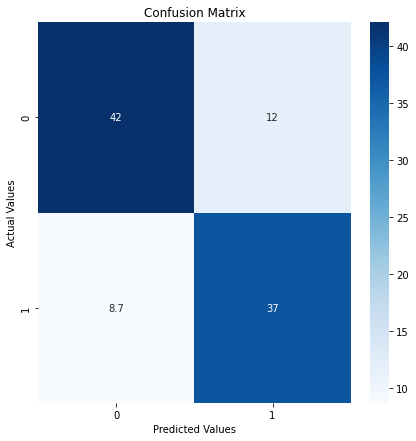

In [46]:
drawConfusionMatrix(best_model_lr.predict(X_test), y_test)

/Users/twobeeornot2be/PycharmProjects/yp_data/venv10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


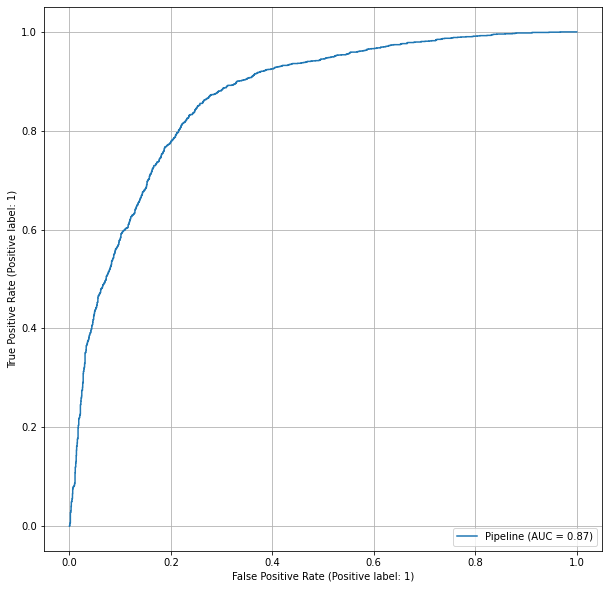

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(best_model_lr, X_test, y_test, ax=ax)
plt.grid()
plt.show()

In [48]:
fnew_feature_names = numerical_feature + list(
    dict(best_model_lr['features'].transformer_list)['categorical'].named_steps['onehotencoder'].get_feature_names_out()
)

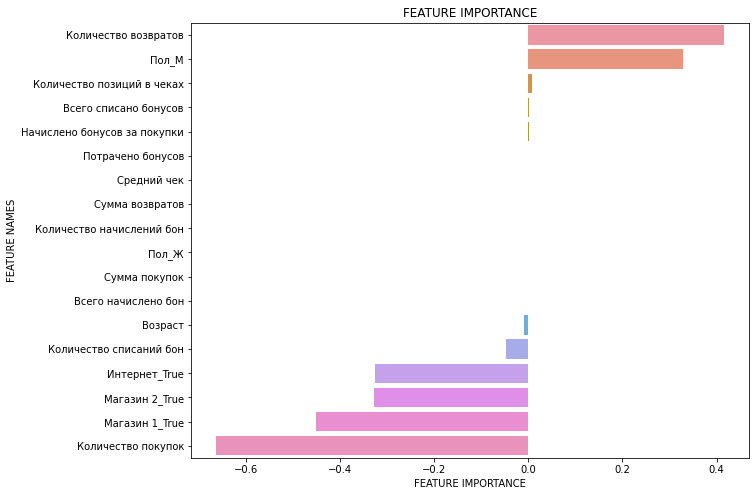

In [49]:
plot_feature_importance(
    list(best_model_lr['model'].coef_[0]),
    fnew_feature_names,
)

### CatBoost

In [50]:
cbc_model = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss='AUC:hints=skip_train~false',
    verbose=False,
    iterations=500,
    cat_features=categorical_feature,
    random_state=RANDOM_STATE,
    auto_class_weights='Balanced',
    # early_stopping_rounds
)

In [51]:
grid = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
    'depth': [2, 3, 4, 5],
    'l2_leaf_reg': [1, 3, 5],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

In [52]:
%%time
randomized_search_result = cbc_model.randomized_search(
    grid,
    X_train,
    y_train,
    cv=5,
    plot=True,
    refit=True,
    stratified=True,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4058474108
bestIteration = 390


bestTest = 0.4078433995
bestIteration = 129


bestTest = 0.4084829441
bestIteration = 119


bestTest = 0.4096434278
bestIteration = 39


bestTest = 0.4064063157
bestIteration = 243


bestTest = 0.4115982053
bestIteration = 70


bestTest = 0.4103282653
bestIteration = 71


bestTest = 0.409472927
bestIteration = 79


bestTest = 0.4077569969
bestIteration = 83


bestTest = 0.4109389043
bestIteration = 57

Training on fold [0/5]

bestTest = 0.4162893905
bestIteration = 188

Training on fold [1/5]

bestTest = 0.4138859045
bestIteration = 334

Training on fold [2/5]

bestTest = 0.4143920907
bestIteration = 441

Training on fold [3/5]

bestTest = 0.4191017217
bestIteration = 157

Training on fold [4/5]

bestTest = 0.4064892292
bestIteration = 263

CPU times: user 6min 7s, sys: 48.5 s, total: 6min 55s
Wall time: 1min 15s


In [53]:
print(f'best result of CatBoostClassifier on train data with parameters:')

for k, v in cbc_model.get_params().items():
    print(k, v)

best result of CatBoostClassifier on train data with parameters:
iterations 500
loss_function Logloss
verbose False
auto_class_weights Balanced
custom_loss AUC:hints=skip_train~false
random_state 42
cat_features ['Магазин 1', 'Магазин 2', 'Интернет', 'Пол']
depth 2
l2_leaf_reg 5
learning_rate 0.2
grow_policy SymmetricTree


In [54]:
cbc_model.fit(X_train, y_train)

prediction = cbc_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, prediction)
print(f"final ROC AUC on test data: {auc}")

final ROC AUC on test data: 0.8954744241659899


f1 score: 0.8064105825489698
accuracy score: 0.8114469772051536
precision score: 0.8526089295320065
recall score: 0.76496138996139


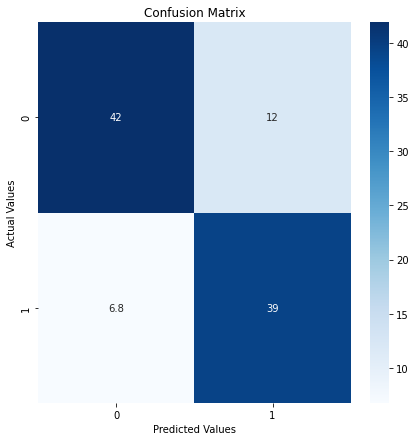

In [55]:
drawConfusionMatrix(cbc_model.predict(X_test), y_test)

/Users/twobeeornot2be/PycharmProjects/yp_data/venv10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


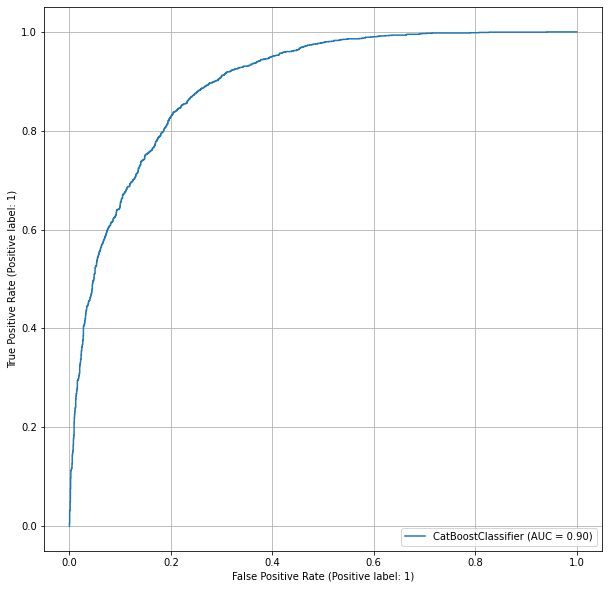

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(cbc_model, X_test, y_test, ax=ax)
plt.grid()
plt.show()

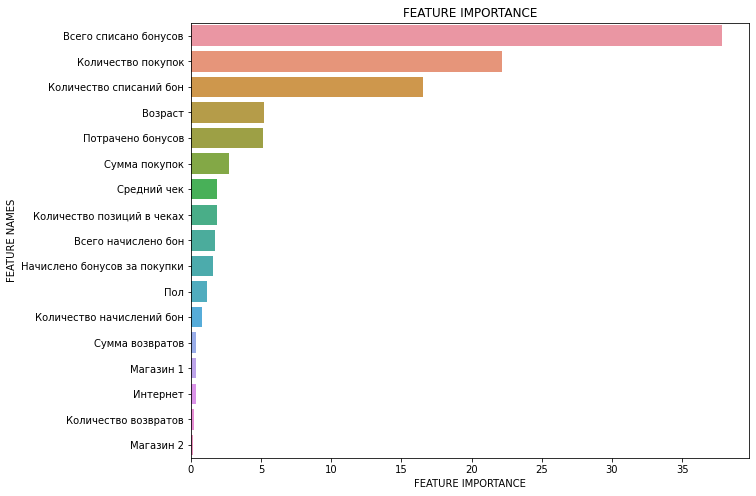

In [57]:
plot_feature_importance(
    cbc_model.get_feature_importance(),
    X_test.columns,
)

## Выводы


Была решена задача предсказания того, соверщит ли клиент следующую покупку или нет. В качестве метрики была выбрана AUC, как наиболее удобная для дальнейшего развития задачи - и выставления порогов бинаризации

При принятии решений о возможном уходе клиента важно обратить внимание на взаимодействие клиента с бонусами.

Получена велечина AUC-ROC `0.89` при использовании `CatBoost`